In [1]:
import pandas as pd
import numpy as np
from scipy import stats as st
import statsmodels.api as sm
from statsmodels.stats.anova import AnovaRM
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def cohen_glass_hedges(x,y):
    nx = len(x)
    ny = len(y)
    pstdnmr = (nx-1)*x.var(ddof=1) + (ny-1)*y.var(ddof=1)   # (n-1)(var1+var2)
    pstddnm = nx + ny - 2                                   # (n-1)*2
    pstd = (pstdnmr / pstddnm)**(0.5)
    cohen = (x.mean() - y.mean()) / pstd
    glass = (x.mean() - y.mean()) / x.std(ddof=1)
    hedges = cohen * (1 - 3/(4 * (nx+ny) - 9) )             # cohen * (1-3/(8*n-9))
    return (cohen, glass, hedges)

In [3]:
am = pd.read_csv('aeroscan_full_melt.csv')
ap = pd.read_csv('aeroscan_full_pivot.csv')

In [4]:
am.head(3)

,ID,sex,location,time,level,parameter,value
0,t1,f,Jurilovca,f,1,rrate,20.690417
1,t2,m,Baia,f,1,rrate,38.483108
2,t3,f,Jurilovca,f,1,rrate,34.786918


In [5]:
ap.head(3)

,ID,sex,location,time,level,rrate,hrate,ventilation,vo2,vo2rel,...,vco2rel,rer,vo2eq,vo2pulse,fat,carb,fat100,carb100,energy,met
0,t1,f,Jurilovca,f,1,20.690417,142.380702,30.818651,1.027298,14.675693,...,16.311019,1.111431,29.999704,7.215153,0.0,312.105589,0.0,100.0,312.105589,4.193055
1,t1,f,Jurilovca,f,2,19.582856,144.350852,30.663501,1.021342,14.590605,...,17.041474,1.167976,30.022744,7.075416,0.0,310.296048,0.0,100.0,310.296048,4.168744
2,t1,f,Jurilovca,f,3,20.252536,156.988301,32.974861,1.071063,15.300896,...,18.420167,1.203862,30.787048,6.822564,0.0,325.401693,0.0,100.0,325.401693,4.371685


In [6]:
aml = am.copy()

In [7]:
aml.parameter.unique()

array(['rrate', 'hrate', 'ventilation', 'vo2', 'vo2rel', 'vco2',
       'vco2rel', 'rer', 'vo2eq', 'vo2pulse', 'fat', 'carb', 'fat100',
       'carb100', 'energy', 'met'], dtype=object)

In [8]:
aml.parameter = aml.parameter.replace(dict(zip(['rrate', 'hrate',
                                                'ventilation', 'vo2', 'vo2rel',
                                                'vco2', 'vco2rel',
                                                'rer', 'vo2eq', 'vo2pulse',
                                                'fat', 'carb',
                                                'fat100', 'carb100', 
                                                'energy', 'met'],
              ['Respiratory rate (breaths/min)', 'Heart rate (beats/min)', 'Ventilation (l/min)', 
               'O2 intake (l/min)', 'Relative O2 intake (ml/kg/min)',
               'CO2 expired (l/min)', 'Relative CO2 expired (ml/kg/min)',
               'Respiratory exchange ratio', 'Ventilation oxygen equivalent (l)', 'O2 per pulse (l)',
               'Fat energy (kcl/h)', 'Carbohydrates energy (kcal/h)',
               'Fat energy %', 'Carbohydrates energy %',
               'Total energy (kcal/h)', 'Metabolic equivalent of task (MET) (3.5ml/kg/min)'])))

In [9]:
aml.time = aml.time.replace(dict(zip(['f','i'],['final', 'initial'])))

In [10]:
aml.columns

Index(['ID', 'sex', 'location', 'time', 'level', 'parameter', 'value'], dtype='object')

In [11]:
aml.columns = ['ID', 'sex', 'Location', 'Time', 'Effort level', 'parameter', 'value']

In [12]:
apl = ap.copy()

In [13]:
apl.columns

Index(['ID', 'sex', 'location', 'time', 'level', 'rrate', 'hrate',
       'ventilation', 'vo2', 'vo2rel', 'vco2', 'vco2rel', 'rer', 'vo2eq',
       'vo2pulse', 'fat', 'carb', 'fat100', 'carb100', 'energy', 'met'],
      dtype='object')

In [14]:
apl.columns = ['ID', 'sex', 'Location', 'Time', 'Effort level',
               'Respiratory rate (breaths/min)', 'Heart rate (beats/min)', 'Ventilation (l/min)', 
               'O2 intake (l/min)', 'Relative O2 intake (ml/kg/min)',
               'CO2 expired (l/min)', 'Relative CO2 expired (ml/kg/min)',
               'Respiratory exchange ratio', 'Ventilation oxygen equivalent (l)', 'O2 per pulse (l)',
               'Fat energy (kcal/h)', 'Carbohydrates energy (kcal/h)',
               'Fat energy %', 'Carbohydrates energy %',
               'Total energy (kcal/h)', 'Metabolic equivalent of task (MET) (3.5ml/kg/min)']

In [15]:
apl.Time = apl.Time.replace(dict(zip(['f','i'],['final', 'initial'])))

In [16]:
# sns.catplot(data=aml,
#             x='Effort level', y='value',
#             hue='Time', hue_order=['initial','final'],
#             col='parameter', row='sex',
#             sharex=False, sharey=False, 
#             kind='point',
#             dodge=True, linewidth=3, estimator='mean', 
#             errorbar='se')

In [17]:
# for col in apl.columns[5:]:
#     mpl.pyplot.figure(figsize=(8,6))
#     sns.set_style("whitegrid")
#     ax = sns.violinplot(data=apl,
#                         x='Effort level', y=col,
#                         hue='Time', hue_order=['initial','final'],
#                         split=False, inner='box')
#     sns.move_legend(ax, "lower right")
#    plt.savefig(f'figures/{col.replace("/"," ")}-violin.pdf')
#    plt.savefig(f'figures/{col.replace("/"," ")}-violin.svg')

In [26]:
# for param in aml.parameter.unique():
#     mpl.pyplot.figure(figsize=(14,6))
#     sns.set_style("whitegrid")
#     sns.catplot(data=aml.loc[aml.parameter==param],
#                 x='Effort level', y='value',
#                 hue='Time', hue_order=['initial','final'],
#                 col='sex',
#                 sharex=False, sharey=True,
#                 kind='violin',
#                 dodge=True).set_ylabels(param)
#     plt.savefig(f'figures/violin-sex/{param.replace("/"," ")}-violin.pdf')
#     plt.savefig(f'figures/violin-sex/{param.replace("/"," ")}-violin.svg')

In [27]:
# for param in aml.parameter.unique()[10:14]:
#     mpl.pyplot.figure(figsize=(14,6))
#     sns.set_style("whitegrid")
#     sns.catplot(data=aml.loc[aml.parameter==param],
#                 x='Effort level', y='value',
#                 hue='Time', hue_order=['initial','final'],
#                 col='sex',
#                 sharex=False, sharey=True,
#                 kind='strip',
#                 dodge=True, linewidth=0.5, estimator='mean',
#                 errorbar='se').set_ylabels(param)
#    plt.savefig(f'figures/strip/{param.replace("/"," ")}-stripplot.pdf')
#    plt.savefig(f'figures/strip/{param.replace("/"," ")}-stripplot.svg')

In [28]:
# f=apl[['ID', 'sex', 'Effort level', 'Time', 'Fat energy (kcal/h)']]
# g=f.groupby(['sex', 'Effort level', 'Time'])['Fat energy (kcal/h)'].agg(
#     lambda x: x.map(lambda y: y==0).sum()).to_frame().reset_index()
# g.columns = ['sex', 'Effort level', 'Time', 'Carbohydrate-exclusive metabolism']

In [29]:
# mpl.pyplot.figure(figsize=(14,6))
# sns.set_style("whitegrid")
# sns.catplot(data=g, x='Effort level', y='Carbohydrate-exclusive metabolism',
#             hue='Time', hue_order=['initial','final'],
#             col='sex', sharey=True, kind='bar')
# plt.savefig('figures/rer-above-1-sex-barplot.pdf')
# plt.savefig('figures/rer-above-1-sex-barplot.svg')

In [30]:
for i in ap.columns[20:]:
    print(i, AnovaRM(data=ap, depvar=i, subject='ID', within=['time', 'level']).fit())

met                  Anova
           F Value Num DF  Den DF Pr > F
----------------------------------------
time        4.4863 1.0000 38.0000 0.0408
level       0.5051 2.0000 76.0000 0.6055
time:level  0.6064 2.0000 76.0000 0.5479



In [31]:
apl[['ID', 'Effort level', 'Time',
     'Respiratory rate (breaths/min)']].pivot(columns=['Effort level', 'Time'],
                                              values='Respiratory rate (breaths/min)',
                                              index='ID').agg(['count',
                                                               'median', 'mean',
                                                               'min', 'max', 'std', 'var',
    lambda x: st.kurtosis(x.copy()),
    lambda y: st.skew(y.copy()),
    lambda z: st.shapiro(z)[0],
    lambda z: st.shapiro(z)[1]]).round(2).sort_index(axis=1,
                                                     level=['Effort level', 'Time'],
                                                     ascending=[True,False])

Effort level       1              2              3       
Time         initial  final initial  final initial  final
count          39.00  39.00   39.00  39.00   39.00  39.00
median         30.78  25.16   31.87  27.38   32.68  27.92
mean           31.63  26.49   33.58  28.22   33.68  29.06
min            10.20  14.57   16.40  13.89    0.00  13.24
max            64.44  51.38   62.23  48.25   66.58  56.55
std             9.95   7.99    9.02   8.06   12.04   8.72
var            98.96  63.83   81.41  65.00  144.89  76.08
<lambda>        2.75   1.32    1.07  -0.49    1.90   1.20
<lambda>        1.19   1.12    0.68   0.30    0.40   0.73
<lambda>        0.91   0.92    0.97   0.98    0.93   0.95
<lambda>        0.00   0.01    0.28   0.64    0.02   0.08

In [32]:
for col in apl.columns[20:]:
    print('\n', col, '\n',
    apl[['ID', 'Effort level', 'Time', col]].pivot(columns=['Effort level', 'Time'],
                                                   values=col,
                                                   index='ID').agg([
    'count', 'median', 'mean',
    'min', 'max', 'std', 'var',
    lambda x: st.kurtosis(x.copy()),
    lambda y: st.skew(y.copy()),
    lambda z: st.shapiro(z)[0],
    lambda z: st.shapiro(z)[1]]).sort_index(axis=1,
                                            level=['Effort level', 'Time'],
                                            ascending=[True,False]).round(2))
#.to_csv(f'{col.replace("/"," ")}.csv')


 Metabolic equivalent of task (MET) (3.5ml/kg/min) 
 Effort level       1              2              3       
Time         initial  final initial  final initial  final
count          39.00  39.00   39.00  39.00   39.00  39.00
median          4.38   4.19    4.44   4.17    4.55   4.07
mean            4.52   4.13    4.61   4.25    4.71   4.14
min             2.45   2.27    2.49   2.50    0.00   2.44
max             8.92   6.42    7.23   5.89    8.84   6.35
std             1.24   1.01    1.14   0.90    1.54   0.94
var             1.55   1.01    1.29   0.80    2.37   0.88
<lambda>        2.33  -0.29   -0.56  -0.82    1.69  -0.45
<lambda>        1.18   0.22    0.25   0.04   -0.02   0.18
<lambda>        0.93   0.98    0.98   0.98    0.96   0.99
<lambda>        0.02   0.85    0.65   0.59    0.13   0.92


In [33]:
# An alternative to iterating over the .groupby object,
# by iterating over categories and then using .get_group

# for param in aml.parameter.unique():
#     print('\n', param)
#     for lev in range(1,4):
#         print(lev)
#         t1 = aml.groupby(['parameter', 'Effort level', 'Time']).get_group((param, lev, 'initial'))
#         t2 = aml.groupby(['parameter', 'Effort level', 'Time']).get_group((param, lev, 'final'))
#         print(st.ttest_rel(t1.value, t2.value))

In [34]:
lev_ttest_res = pd.DataFrame(data=None,
                             index=range(48),
                             columns=['Parameter', 'Effort level',
                                      'Significance level',
                                      'Degrees of freedom',
                                      'T critical (two tailed)',
                                      'T statistic', 'T test p-value (two-tailed)',
                                      'Levene statistic', 'Levene p-value',
                                      'Effect size (Cohen d)'])
lev_ttest_res['Significance level'] = 0.05

In [35]:
k = 0
for i, j in aml.groupby(['parameter', 'Effort level'], sort=False):
    t_pair = j.pivot(columns='Time', values='value', index='ID').reset_index()
    t_res = st.ttest_rel(t_pair.initial, t_pair.final, alternative='two-sided')
    levene = st.levene(t_pair.initial, t_pair.final)
    cohen = cohen_glass_hedges(t_pair.initial, t_pair.final)
    lev_ttest_res.loc[k, 'Parameter'] = i[0]
    lev_ttest_res.loc[k, 'Effort level'] = i[1]
    lev_ttest_res.loc[k, 'Degrees of freedom'] = len(t_pair.initial) - 1
    lev_ttest_res.loc[k, 'T critical (two tailed)'] = st.t.ppf(0.025, len(t_pair.initial) - 1).round(2)
    lev_ttest_res.loc[k, 'T statistic'] = t_res[0].round(2)
    lev_ttest_res.loc[k, 'T test p-value (two-tailed)'] = t_res[1].round(3)
    lev_ttest_res.loc[k, 'Levene statistic'] = levene[0].round(2)
    lev_ttest_res.loc[k, 'Levene p-value'] = levene[1].round(3)
    lev_ttest_res.loc[k, 'Effect size (Cohen d)'] = cohen[0].round(2)
    k += 1
    
results_df = lev_ttest_res.pivot(columns='Effort level',
                                 index='Parameter',
                                 values=['Significance level',
                                         'Degrees of freedom',
                                         'T critical (two tailed)',
                                         'T statistic', 'T test p-value (two-tailed)',
                                         'Levene statistic', 'Levene p-value',
                                         'Effect size (Cohen d)']).T
results_df.columns.names = [None]

## order = { l : i for i : l in enumerate(list)}
## df.sort_index(key=lambda x: x.map(order))

In [36]:
[(i, j) for i, j in enumerate(aml.parameter.unique())]

[(0, 'Respiratory rate (breaths/min)'),
 (1, 'Heart rate (beats/min)'),
 (2, 'Ventilation (l/min)'),
 (3, 'O2 intake (l/min)'),
 (4, 'Relative O2 intake (ml/kg/min)'),
 (5, 'CO2 expired (l/min)'),
 (6, 'Relative CO2 expired (ml/kg/min)'),
 (7, 'Respiratory exchange ratio'),
 (8, 'Ventilation oxygen equivalent (l)'),
 (9, 'O2 per pulse (l)'),
 (10, 'Fat energy (kcl/h)'),
 (11, 'Carbohydrates energy (kcal/h)'),
 (12, 'Fat energy %'),
 (13, 'Carbohydrates energy %'),
 (14, 'Total energy (kcal/h)'),
 (15, 'Metabolic equivalent of task (MET) (3.5ml/kg/min)')]

In [37]:
param_order = {label : index for index, label in enumerate(aml.parameter.unique())}

In [38]:
param_order

{'Respiratory rate (breaths/min)': 0,
 'Heart rate (beats/min)': 1,
 'Ventilation (l/min)': 2,
 'O2 intake (l/min)': 3,
 'Relative O2 intake (ml/kg/min)': 4,
 'CO2 expired (l/min)': 5,
 'Relative CO2 expired (ml/kg/min)': 6,
 'Respiratory exchange ratio': 7,
 'Ventilation oxygen equivalent (l)': 8,
 'O2 per pulse (l)': 9,
 'Fat energy (kcl/h)': 10,
 'Carbohydrates energy (kcal/h)': 11,
 'Fat energy %': 12,
 'Carbohydrates energy %': 13,
 'Total energy (kcal/h)': 14,
 'Metabolic equivalent of task (MET) (3.5ml/kg/min)': 15}

In [39]:
results_df.sort_index(axis=1, 
                      key=lambda x: x.map(param_order),
                      inplace=True)

In [40]:
# results_df.to_csv('ttresults.csv')
# results_df.to_excel('ttresults.xlsx')

### More ways to rename columns

In [41]:
ren = results_df.reset_index()
ren.head(1)

,level_0,Effort level,Respiratory rate (breaths/min),Heart rate (beats/min),Ventilation (l/min),O2 intake (l/min),Relative O2 intake (ml/kg/min),CO2 expired (l/min),Relative CO2 expired (ml/kg/min),Respiratory exchange ratio,Ventilation oxygen equivalent (l),O2 per pulse (l),Fat energy (kcl/h),Carbohydrates energy (kcal/h),Fat energy %,Carbohydrates energy %,Total energy (kcal/h),Metabolic equivalent of task (MET) (3.5ml/kg/min)
0,Significance level,1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


In [42]:
ren.columns[0]                    # However, cannot assign a value to it (immutable)

'level_0'

In [43]:
ren.columns.values[0]             # This is mutable

'level_0'

In [44]:
ren.columns.get_loc('level_0')    # Find numeric index of column name

0

In [45]:
ren.columns.values[ren.columns.get_loc('level_0')] = 'Statistic'
# Very cumbersome way to avoid indices, dictionaries or list assignment

In [46]:
ren.columns[0]

'Statistic'

In [47]:
ren.columns.map(param_order.get)
# .get() is really a function, but that is not visible inside .map()
# {key:value}.get(key) takes the input and transforms it with the attached dict
# the input is searched in the dict keys and if found, the corresponding value is output
# if the value is not found, the output is None

Index([ nan,  nan,  0.0,  1.0,  2.0,  3.0,  4.0,  5.0,  6.0,  7.0,  8.0,  9.0,
       10.0, 11.0, 12.0, 13.0, 14.0, 15.0],
      dtype='float64')

In [48]:
ren.columns.map({'Statistic':'stat'}.get)

Index(['stat',   None,   None,   None,   None,   None,   None,   None,   None,
         None,   None,   None,   None,   None,   None,   None,   None,   None],
      dtype='object')

In [49]:
ren.columns = ren.columns.map({'Statistic':'stat'}.get)

In [50]:
ren.head(1)

,stat,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
0,Significance level,1,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05


# ZIP

In [51]:
print(list(zip(['f','i'],['final', 'initial'])))
# zip is an object used to pair elements of lists, tuples, etc, into tuples
# must be converted into lists, tuples, dictionaries, sets etc to be seen or accessed
# if converted into dictionary, it does not contain tuples anymore

[('f', 'final'), ('i', 'initial')]


In [52]:
print(dict(zip(['f','i'],['final', 'initial'])))

{'f': 'final', 'i': 'initial'}


In [53]:
{i:j for i, j in zip(['f','i'],['final', 'initial'])}

{'f': 'final', 'i': 'initial'}

In [54]:
print(*['final', 'initial'])   # unpacking operator

final initial


In [55]:
print(*{'a':'b','A':'B'})      # * unpacks just the keys

a A


In [56]:
z = zip(['f','i'],['final', 'initial'])

In [57]:
print(list(zip(z)))            # needs unpacking

[(('f', 'final'),), (('i', 'initial'),)]


In [58]:
z = zip(['f','i'],['final', 'initial'])    #list() or dict() changes zip inplace, becomes empty

In [59]:
print(*z)                      # unpacks zip

('f', 'final') ('i', 'initial')


In [60]:
z = zip(['f','i'],['final', 'initial'])

In [61]:
print(list(zip(*z)))
#   Use zip again on the unpacked list to unzip
#   Zip is a kind of transpose function

[('f', 'i'), ('final', 'initial')]


## Aggregation

In [62]:
# Groupby all columns except the one whose categories need aggregation (Effort Level)
# We are left with just one value column (value) that we aggregate (mean)
# We create a frame from the output and reset the resulting multiindex into columns

agg_level_melt = aml.groupby(['ID', 'sex','Location', 'parameter', 'Time'],
                             sort=False).value.mean().to_frame().reset_index()

In [63]:
agg_level_melt.head(2)

,ID,sex,Location,parameter,Time,value
0,t1,f,Jurilovca,Respiratory rate (breaths/min),final,20.175270
1,t2,m,Baia,Respiratory rate (breaths/min),final,34.738224


In [64]:
# Unappropiate use of unstack gives erroneous result
#
#
# Create multiindex, unstack the last level, 'Time'
agg_level_pivot_time = agg_level_melt.set_index(['ID', 'sex', 'Location', 'parameter', 'Time'],
                                                drop=True,        #default - don't keep columns
                                                append=False,     #default - don.t keep old index
                                                inplace=False,    #default - don.t save new dataframe
                                               ).unstack(level='Time', sort=False)

In [65]:
agg_level_pivot_time.head(2)

value           
Time                                                 final    initial
ID sex Location  parameter                                           
t1 f   Jurilovca Respiratory rate (breaths/min)  20.175270  34.738224
t2 m   Baia      Respiratory rate (breaths/min)  35.978903  29.564220

In [66]:
agg_level_pivot_time.index[0]

('t1', 'f', 'Jurilovca', 'Respiratory rate (breaths/min)')

In [67]:
agg_level_pivot_time.index.names

FrozenList(['ID', 'sex', 'Location', 'parameter'])

In [68]:
agg_level_pivot_time.columns

MultiIndex([('value',   'final'),
            ('value', 'initial')],
           names=[None, 'Time'])

In [69]:
agg_level_pivot_time.columns.names = ['level 0', 'Time'] 
# .rename_axis(columns=['lev0', 'Time']) does the same job

In [70]:
agg_level_pivot_time.columns

MultiIndex([('value',   'final'),
            ('value', 'initial')],
           names=['level 0', 'Time'])

In [71]:
agg_level_pivot_time.head(1)

level 0                                             value           
Time                                                final    initial
ID sex Location  parameter                                          
t1 f   Jurilovca Respiratory rate (breaths/min)  20.17527  34.738224

In [72]:
agg_level_pivot_time.reset_index(col_fill='x').head(1)
# Only resets index multiindex and moves it by default on the first column level (level 0)

level 0  ID sex   Location                       parameter     value  \
Time      x   x          x                               x     final   
0        t1   f  Jurilovca  Respiratory rate (breaths/min)  20.17527   

level 0             
Time       initial  
0        34.738224

In [73]:
agg_level_pivot_time.reset_index(col_level=1, col_fill='x', inplace=True)

In [74]:
agg_level_pivot_time.head(1)
# 'x' is really repeated but not shown as such, because of hierarchy

level 0   x                                                    value  \
Time     ID sex   Location                       parameter     final   
0        t1   f  Jurilovca  Respiratory rate (breaths/min)  20.17527   

level 0             
Time       initial  
0        34.738224

In [75]:
agg_level_pivot_time.columns

MultiIndex([(    'x',        'ID'),
            (    'x',       'sex'),
            (    'x',  'Location'),
            (    'x', 'parameter'),
            ('value',     'final'),
            ('value',   'initial')],
           names=['level 0', 'Time'])

In [76]:
agg_level_pivot_time.columns.droplevel(0)

Index(['ID', 'sex', 'Location', 'parameter', 'final', 'initial'], dtype='object', name='Time')

In [77]:
agg_level_pivot_time = agg_level_pivot_time.droplevel(axis=1, level=0)
# default axis=0, removes index levels, can also accept axis names

In [78]:
agg_level_pivot_time.columns.names = [None]    #Initially named 'Time'

In [79]:
agg_level_pivot_time.head(1)

,ID,sex,Location,parameter,final,initial
0,t1,f,Jurilovca,Respiratory rate (breaths/min),20.17527,34.738224


In [80]:
agg_level_pivot_time.columns

Index(['ID', 'sex', 'Location', 'parameter', 'final', 'initial'], dtype='object')

In [81]:
agg_level_pivot_time = agg_level_pivot_time[['ID', 'sex', 'Location',
                                             'parameter', 'initial', 'final']]

In [82]:
agg_ttest_res = pd.DataFrame(data=None,
                             index=range(16),
                             columns=['Parameter',
                                      'Significance level',
                                      'Degrees of freedom',
                                      'T critical (two tailed)',
                                      'T statistic', 'T test p-value (two-tailed)',
                                      'Levene statistic', 'Levene p-value',
                                      'Effect size (Cohen d)'])
agg_ttest_res['Significance level'] = 0.05

In [83]:
k = 0
for i, j in agg_level_pivot_time.groupby('parameter', sort=False):
    t_res = st.ttest_rel(j.initial, j.final, alternative='two-sided')
    levene = st.levene(j.initial, j.final)
    cohen = cohen_glass_hedges(j.initial, j.final)
    agg_ttest_res.loc[k, 'Parameter'] = i
    agg_ttest_res.loc[k, 'Degrees of freedom'] = len(j.initial) - 1
    agg_ttest_res.loc[k, 'T critical (two tailed)'] = - st.t.ppf(0.025, len(j.initial) - 1).round(2)
    agg_ttest_res.loc[k, 'T statistic'] = t_res[0].round(2)
    agg_ttest_res.loc[k, 'T test p-value (two-tailed)'] = t_res[1].round(3)
    agg_ttest_res.loc[k, 'Levene statistic'] = levene[0].round(2)
    agg_ttest_res.loc[k, 'Levene p-value'] = levene[1].round(3)
    agg_ttest_res.loc[k, 'Effect size (Cohen d)'] = cohen[0].round(2)
    k += 1

In [84]:
agg_ttest_res = agg_ttest_res.set_index('Parameter').T
agg_ttest_res

Parameter,Respiratory rate (breaths/min),Heart rate (beats/min),Ventilation (l/min),O2 intake (l/min),Relative O2 intake (ml/kg/min),CO2 expired (l/min),Relative CO2 expired (ml/kg/min),Respiratory exchange ratio,Ventilation oxygen equivalent (l),O2 per pulse (l),Fat energy (kcl/h),Carbohydrates energy (kcal/h),Fat energy %,Carbohydrates energy %,Total energy (kcal/h),Metabolic equivalent of task (MET) (3.5ml/kg/min)
Significance level,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
Degrees of freedom,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
T critical (two tailed),2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02
T statistic,-0.4,0.51,-0.42,-0.53,-0.5,-0.48,-0.3,-0.19,-0.08,-1.06,-0.31,-0.32,-0.32,0.09,-0.52,-0.5
T test p-value (two-tailed),0.689,0.611,0.679,0.6,0.617,0.633,0.765,0.849,0.939,0.294,0.755,0.753,0.753,0.931,0.609,0.617
Levene statistic,0.26,0.49,1.48,0.34,0.21,1.22,0.53,0.02,0.41,0.03,0.16,1.36,0.12,0.01,0.49,0.21
Levene p-value,0.614,0.485,0.227,0.564,0.648,0.272,0.467,0.901,0.525,0.854,0.69,0.247,0.726,0.918,0.484,0.648
Effect size (Cohen d),-0.09,0.13,-0.1,-0.14,-0.12,-0.12,-0.07,-0.04,-0.02,-0.27,-0.07,-0.08,-0.07,0.02,-0.13,-0.12


In [85]:
agg_level_melt.columns

Index(['ID', 'sex', 'Location', 'parameter', 'Time', 'value'], dtype='object')

In [86]:
# for i, j in agg_level_melt.groupby('parameter', sort=False):
#     mpl.pyplot.figure(figsize=(14,6))
#     sns.set_style("whitegrid")
#     sns.catplot(data=j,
#                 x='sex', y='value',
#                 hue='Time', hue_order=['initial','final'],
#                 sharex=False, sharey=True,
#                 kind='violin',
#                ).set_ylabels(i)
#     plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-violinplot-simple.pdf')
#     plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-violinplot-simple.svg')

In [87]:
amagg = am.pivot(values='value',
                 index=['ID', 'sex', 'location', 'parameter', 'time'],
                 columns='level').reset_index()

In [88]:
short_param_order = {label : index for index, label in enumerate(am.parameter.unique())}

In [89]:
amagg.sort_values(by=['parameter','ID'],
                  ignore_index=True,
                  inplace=True,
                  key=lambda x: x.map(short_param_order))

In [90]:
amagg['mean_l'] = 0.01

In [91]:
amagg.columns

Index(['ID', 'sex', 'location', 'parameter', 'time', 1, 2, 3, 'mean_l'], dtype='object', name='level')

In [92]:
amagg.loc[:,'mean_l'] = amagg.loc[:,[1,2,3]].apply(axis=1, func='mean')

In [93]:
amagg.drop(columns=[1,2,3], inplace=True)

In [94]:
apagg = amagg.pivot(columns='time',
                    index=['ID', 'sex', 'location', 'parameter'],
                    values='mean_l').reset_index().sort_values(by=['parameter','ID'],
                                                               ignore_index=True,
                                                               key=lambda x: x.map(short_param_order))

In [95]:
shagg_ttest_res = pd.DataFrame(data=None,
                               index=range(16),
                               columns=['Parameter',
                                        'Significance level',
                                        'Degrees of freedom',
                                        'T critical (two tailed)',
                                        'T statistic', 'T test p-value (two-tailed)',
                                        'Levene statistic', 'Levene p-value',
                                        'Effect size (Cohen d)'])
shagg_ttest_res['Significance level'] = 0.05

In [96]:
# Troubleshooting
# agglm_temp = agg_level_melt.copy()
# agglm_temp.Time = agglm_temp.Time.replace(dict(zip(['final', 'initial'],['f','i'])))
# agglm_temp = agglm_temp.pivot(columns='Time',
#                  index=['ID', 'sex', 'Location', 'parameter'],
#                  values='value').reset_index().sort_values(by=['parameter','ID'],
#                                                                ignore_index=True,
#                                                                key=lambda x: x.map(param_order))

In [97]:
k = 0
for param in apagg.parameter.unique():
    t_pair = apagg.loc[apagg.parameter==param]
    t_res = st.ttest_rel(t_pair.i, t_pair.f, alternative='two-sided')
    levene = st.levene(t_pair.i, t_pair.f)
    cohen = cohen_glass_hedges(t_pair.i, t_pair.f)
    shagg_ttest_res.loc[k, 'Parameter'] = param
    shagg_ttest_res.loc[k, 'Degrees of freedom'] = len(t_pair.i) - 1
    shagg_ttest_res.loc[k, 'T critical (two tailed)'] = - st.t.ppf(0.025, len(t_pair.i) - 1).round(2)
    shagg_ttest_res.loc[k, 'T statistic'] = t_res[0].round(2)
    shagg_ttest_res.loc[k, 'T test p-value (two-tailed)'] = t_res[1].round(3)
    shagg_ttest_res.loc[k, 'Levene statistic'] = levene[0].round(2)
    shagg_ttest_res.loc[k, 'Levene p-value'] = levene[1].round(3)
    shagg_ttest_res.loc[k, 'Effect size (Cohen d)'] = cohen[0].round(2)
    k += 1

In [98]:
shagg_ttest_res.set_index('Parameter').T

Parameter,rrate,hrate,ventilation,vo2,vo2rel,vco2,vco2rel,rer,vo2eq,vo2pulse,fat,carb,fat100,carb100,energy,met
Significance level,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05,0.05
Degrees of freedom,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38,38
T critical (two tailed),2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02,2.02
T statistic,2.65,2.75,3.6,2.1,2.12,3.15,3.12,2.35,2.83,0.25,-2.07,2.67,-2.02,1.86,2.18,2.12
T test p-value (two-tailed),0.012,0.009,0.001,0.042,0.041,0.003,0.003,0.024,0.007,0.804,0.045,0.011,0.051,0.071,0.036,0.041
Levene statistic,0.8,0.0,3.99,0.65,3.55,2.09,5.39,4.78,3.8,0.41,1.47,0.4,2.07,1.3,0.64,3.55
Levene p-value,0.373,0.959,0.049,0.423,0.063,0.152,0.023,0.032,0.055,0.525,0.229,0.528,0.154,0.257,0.428,0.063
Effect size (Cohen d),0.59,0.58,0.74,0.4,0.44,0.63,0.69,0.55,0.67,0.05,-0.46,0.56,-0.47,0.41,0.42,0.44


In [99]:
# shagg_ttest_res.set_index('Parameter').T.to_excel('ttagg.xlsx')

In [101]:
# for i, j in amagg.groupby('parameter', sort=False):
#     mpl.pyplot.figure(figsize=(14,6))
#     sns.set_style("whitegrid")
#     sns.catplot(data=j,
#                 #col='sex',
#                 x='sex', y='mean_l',
#                 hue='time', hue_order=['i','f'],
#                 sharex=False, sharey=True,
#                 kind='violin', dodge=True,
#                ).set_ylabels(short_to_long[i])
#     plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-simple-violin.pdf')
#     plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-simple-violin.svg')

In [173]:
agg_param_pivot = agg_level_melt.pivot(index=['ID', 'sex',
                                              'Location', 'Time'],
                                       columns='parameter',
                                       values='value').sort_index(
    axis=1,
    key=lambda x: x.map(param_order))

In [258]:
agg_descr = agg_param_pivot.groupby('Time').apply(
    
                lambda p: p.agg(
                                ['count', 'median', 'mean',
                                'min', 'max', 'std', 'var',
                                lambda a: st.kurtosis(a.copy()),
                                lambda b: st.skew(b.copy()),
                                lambda c: st.shapiro(c)[0],
                                lambda d: st.shapiro(d)[1]]
                                                           )
    
                    ).reorder_levels(order=[1, 0]).reset_index()

agg_descr.columns.name = None
agg_descr.columns.values[0] = 'Statistic'
agg_descr.loc[[7,8,9,10,18,19,20,21], 'Statistic'] = ['Kurtosis', 'Skewness',
                                                      'Shapiro statistic',
                                                      'Shapiro p-value',
                                                      'Kurtosis', 'Skewness',
                                                      'Shapiro statistic',
                                                      'Shapiro p-value']

descr_order = {lb:i for i,lb in enumerate(agg_descr.loc[0:10, 'Statistic'])}
agg_descr.Time = agg_descr.Time.str.replace('final','test_final')
agg_descr = agg_descr.sort_values('Time')
agg_descr = agg_descr.sort_values(['Statistic','Time'],
                                  key=lambda x: x.map(descr_order),
                                  ignore_index=True)
agg_descr.Time = agg_descr.Time.str.replace('test_final','final')
agg_descr.set_index(['Statistic','Time'],
                    inplace=True)

In [100]:
short_to_long = dict(zip(short_param_order,param_order))

In [103]:
short_to_long['carb100']

'Carbohydrates energy %'

In [296]:
# carbfat100 = aml.loc[(aml.parameter==short_to_long['carb100']) | (aml.parameter==short_to_long['fat100'])]
carbfat100 = aml.loc[aml.parameter==short_to_long['carb100']]

<Figure size 1400x1400 with 0 Axes>

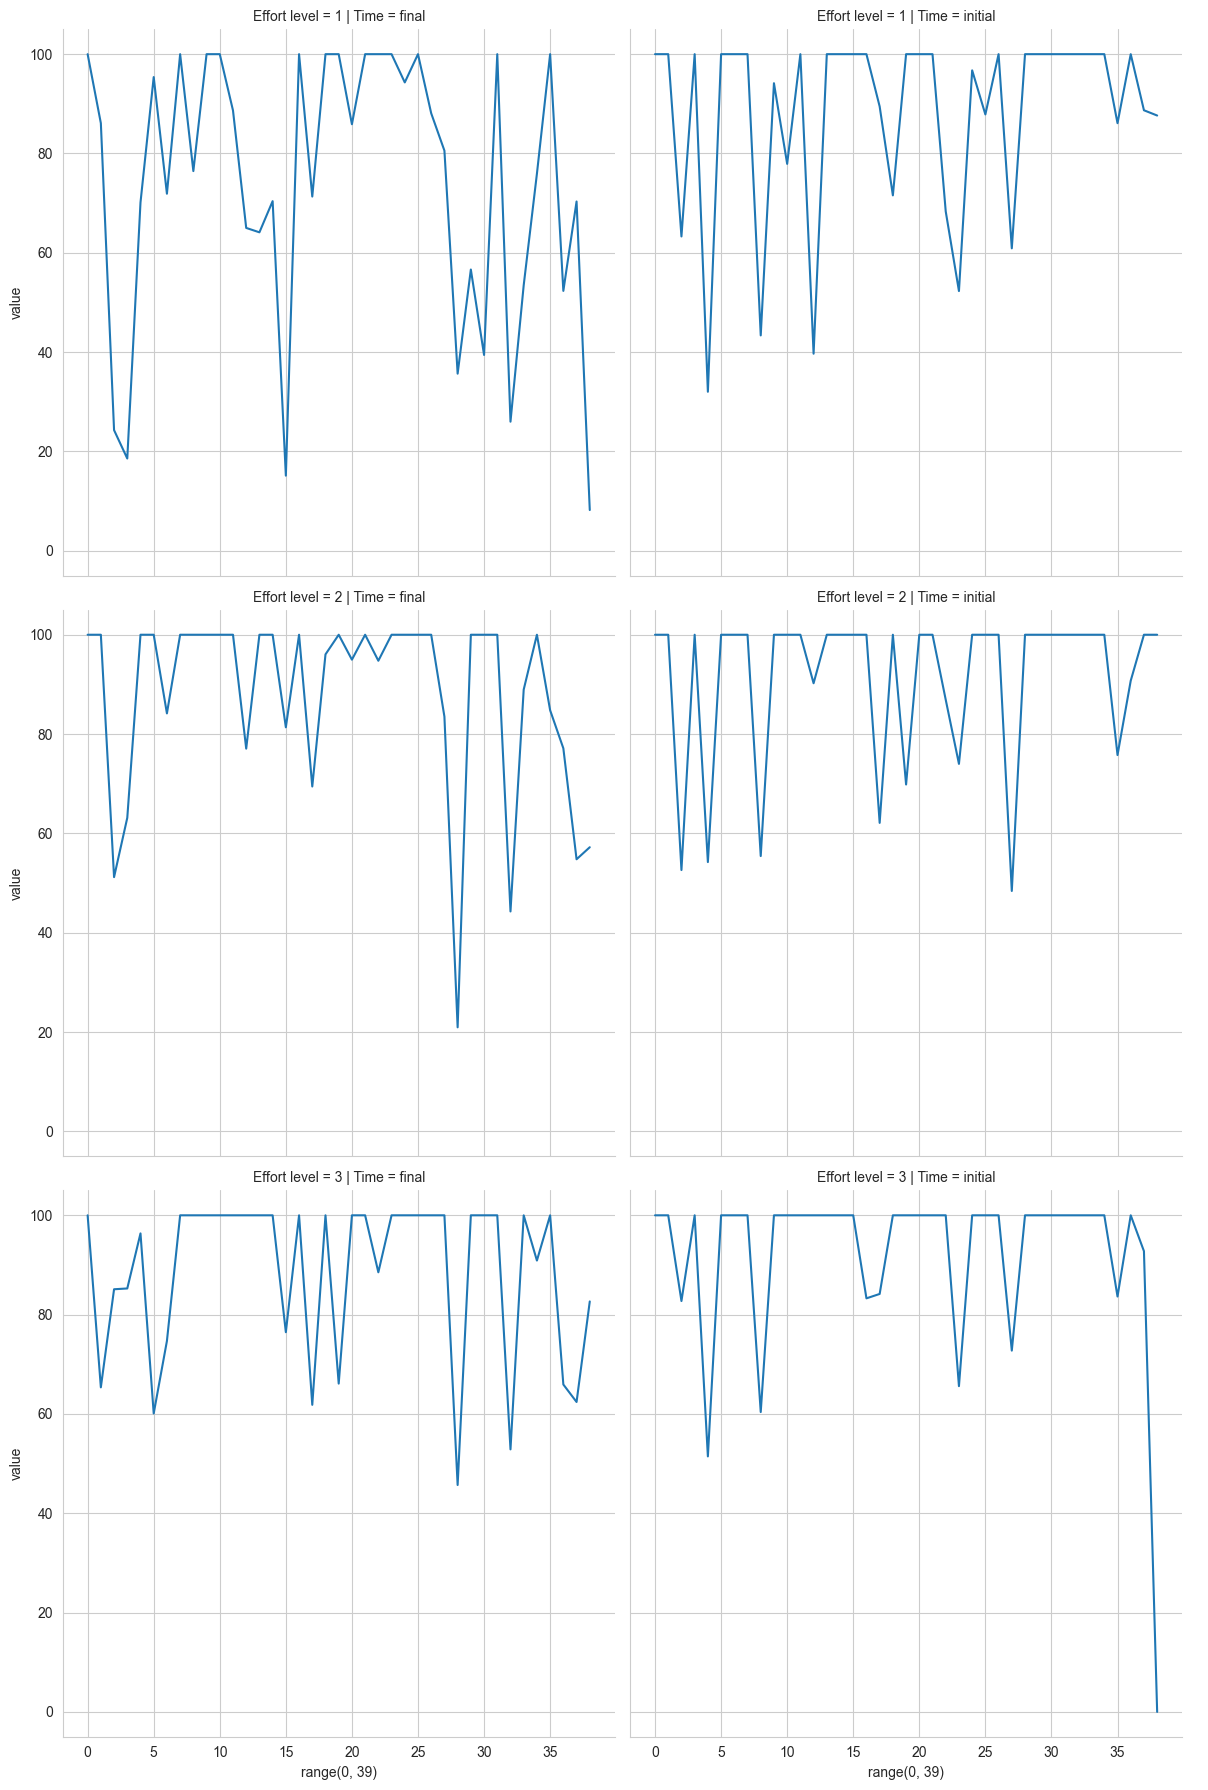

In [298]:
mpl.pyplot.figure(figsize=(14,14))
sns.set_style("whitegrid")

fgrid = sns.FacetGrid(carbfat100,
                      row='Effort level', col='Time',
                      height=6)

fgrid.map_dataframe(sns.lineplot,
                    x=range(0,39),
                    y='value')
fgrid.add_legend()
# elem: bars, step, poly
# multiple: layer, dodge, stack, fill
# plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-simple-violin.pdf')
# plt.savefig(f'figures/agg/simple/{i.replace("/"," ")}-simple-violin.svg')